# Synthesising all the results

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from adjustText import adjust_text
from collections import OrderedDict

In [7]:
csv_dir = Path("output/bash/concatenated_reports/")
csv_files = [f for f in csv_dir.glob("*.csv") if f.name != "all_models.csv"]
df_concat = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

df = df_concat.copy()
df.to_csv('output/bash/concatenated_reports/all_models.csv')

In [8]:
# remove outliers
df_filtered = df[df["normalized_error"] < 10]
df_filtered = df_filtered[df_filtered["country"] != "Unknown"]
df_filtered = df_filtered[['NUTS_NAME', 'LEVL_CODE', 'country', 'predicted',
       'error_deviation', 'normalized_error_deviation', 'logprobs', 'logprobs_deviation', 'error',
       'normalized_error', 'indicator', 'expe', 'model',]]

In [9]:
df_filtered.keys()

Index(['NUTS_NAME', 'LEVL_CODE', 'country', 'predicted', 'error_deviation',
       'normalized_error_deviation', 'logprobs', 'logprobs_deviation', 'error',
       'normalized_error', 'indicator', 'expe', 'model'],
      dtype='object')

In [10]:
df_filtered

,NUTS_NAME,LEVL_CODE,country,predicted,error_deviation,normalized_error_deviation,logprobs,logprobs_deviation,error,normalized_error,indicator,expe,model
0,Nordburgenland,3,Austria,6.0,6.0,0.171429,-0.590775,0.507814,5.0,0.142857,age_index,relative,Mistral-Small-24B-Instruct-2501
1,Südburgenland,3,Austria,5.0,8.0,0.228571,-0.615942,0.720973,3.0,0.085714,age_index,relative,Mistral-Small-24B-Instruct-2501
2,Mittelburgenland,3,Austria,7.0,8.0,0.228571,-0.445966,0.632117,5.0,0.142857,age_index,relative,Mistral-Small-24B-Instruct-2501
3,Weinviertel,3,Austria,9.0,3.0,0.085714,-0.347870,0.407123,8.0,0.228571,age_index,relative,Mistral-Small-24B-Instruct-2501
4,Liezen,3,Austria,9.0,4.0,0.114286,-0.501073,0.511359,7.0,0.200000,age_index,relative,Mistral-Small-24B-Instruct-2501
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80966,Ortadoğu Anadolu,1,Türkiye,10625.0,744.0,0.100270,-0.185244,0.074380,5925.0,1.260638,income,absolute,Mistral-7B-Instruct-v0.3
80968,Slovenija,1,Slovenia,23810.0,672.0,0.035533,-0.292342,0.113341,3010.0,0.144712,income,absolute,Mistral-7B-Instruct-v0.3
80969,Slovensko,1,Slovakia,20420.0,312.0,0.018706,-0.267152,0.091524,4820.0,0.308974,income,absolute,Mistral-7B-Instruct-v0.3
80972,Batı Marmara,1,Türkiye,12200.0,1135.0,0.152965,-0.264254,0.128684,2500.0,0.257732,income,absolute,Mistral-7B-Instruct-v0.3


In [11]:
import pandas as pd
import numpy as np

df_table = df_filtered.copy()

# df_table['category'] = df_table['indicator']
metrics = ['error', 'normalized_error', 'logprobs']

# Step 2: Build long-format summary
summary_rows = []

# Total row
for model in df_table['model'].unique():
    for metric in metrics:
        summary_rows.append({
            'indicator': 'Total',
            'metric': metric,
            'model': model,
            'value': df_table[df_table['model'] == model][metric].mean(),
            'deviation': df_table[df_table['model'] == model][metric].std()
        })

# Per category
for cat in df_table['indicator'].unique():
    for model in df_table['model'].unique():
        for metric in metrics:
            value = df_table[(df_table['model'] == model) & (df_table['indicator'] == cat)][metric].mean()
            summary_rows.append({
                'indicator': cat,
                'metric': metric,
                'model': model,
                'value': value,
                'deviation': df_table[df_table['model'] == model][metric].std()
            })

df_summary = pd.DataFrame(summary_rows)
df_summary


,indicator,metric,model,value,deviation
0,Total,error,Mistral-Small-24B-Instruct-2501,-542.109690,6281.036830
1,Total,normalized_error,Mistral-Small-24B-Instruct-2501,0.354615,0.477598
2,Total,logprobs,Mistral-Small-24B-Instruct-2501,-0.558759,0.273824
3,Total,error,Qwen2.5-32B-Instruct,45.812615,5989.441624
4,Total,normalized_error,Qwen2.5-32B-Instruct,0.430067,0.586325
...,...,...,...,...,...
115,income,normalized_error,Qwen2.5-7B-Instruct,0.396959,0.935593
116,income,logprobs,Qwen2.5-7B-Instruct,-0.071503,0.124344
117,income,error,Mistral-7B-Instruct-v0.3,3056.701910,6943.179660
118,income,normalized_error,Mistral-7B-Instruct-v0.3,0.387625,0.727518


In [12]:
# add $_$ value to print the latex table
def to_math_mode(val):
    if isinstance(val, str) and '_' in val:
        return f"{val.split('_')[0]} {val.split('_')[1]}"
    return val

def truncate_models(val):
    return val.split("-Instruct")[0]

df_summary["metric"] = df_summary["metric"].apply(to_math_mode)
df_summary["model"] = df_summary["model"].apply(to_math_mode)
df_summary["model"] = df_summary["model"].apply(truncate_models)
df_summary["indicator"] = df_summary["indicator"].apply(to_math_mode)
df_summary


,indicator,metric,model,value,deviation
0,Total,error,Mistral-Small-24B,-542.109690,6281.036830
1,Total,normalized error,Mistral-Small-24B,0.354615,0.477598
2,Total,logprobs,Mistral-Small-24B,-0.558759,0.273824
3,Total,error,Qwen2.5-32B,45.812615,5989.441624
4,Total,normalized error,Qwen2.5-32B,0.430067,0.586325
...,...,...,...,...,...
115,income,normalized error,Qwen2.5-7B,0.396959,0.935593
116,income,logprobs,Qwen2.5-7B,-0.071503,0.124344
117,income,error,Mistral-7B,3056.701910,6943.179660
118,income,normalized error,Mistral-7B,0.387625,0.727518


In [13]:
# remove error for Total because it doesn't have any sens to keep it
df_summary.loc[
    (df_summary["indicator"] == "Total") & (df_summary["metric"] == "error"),
    "value"
] = np.nan
df_summary.loc[
    (df_summary["indicator"] == "Total") & (df_summary["metric"] == "error"),
    "deviation"
] = np.nan

df_summary


,indicator,metric,model,value,deviation
0,Total,error,Mistral-Small-24B,NaN,NaN
1,Total,normalized error,Mistral-Small-24B,0.354615,0.477598
2,Total,logprobs,Mistral-Small-24B,-0.558759,0.273824
3,Total,error,Qwen2.5-32B,NaN,NaN
4,Total,normalized error,Qwen2.5-32B,0.430067,0.586325
...,...,...,...,...,...
115,income,normalized error,Qwen2.5-7B,0.396959,0.935593
116,income,logprobs,Qwen2.5-7B,-0.071503,0.124344
117,income,error,Mistral-7B,3056.701910,6943.179660
118,income,normalized error,Mistral-7B,0.387625,0.727518


In [14]:
df_summary["model"].unique()

array(['Mistral-Small-24B', 'Qwen2.5-32B', 'Qwen2.5-14B', 'Qwen2.5-72B',
       'Llama-3.1-8B', 'Llama-3.1-70B', 'Qwen2.5-7B', 'Mistral-7B'],
      dtype=object)

In [15]:
# re-order models
model_order = [
    "Mistral-7B",
    "Mistral-Small-24B",
    "Qwen2.5-7B",
    "Qwen2.5-14B",
    "Qwen2.5-32B",
    "Qwen2.5-72B",
    "Llama-3.1-8B",
    "Llama-3.1-70B",
]

df_summary["model"] = pd.Categorical(df_summary["model"], categories=model_order, ordered=True)
df_summary = df_summary.sort_values(by=["indicator", "model"])
df_summary

,indicator,metric,model,value,deviation
21,Total,error,Mistral-7B,NaN,NaN
22,Total,normalized error,Mistral-7B,0.516559,0.727518
23,Total,logprobs,Mistral-7B,-0.300002,0.223817
0,Total,error,Mistral-Small-24B,NaN,NaN
1,Total,normalized error,Mistral-Small-24B,0.354615,0.477598
...,...,...,...,...,...
61,poverty,normalized error,Llama-3.1-8B,0.421222,0.596091
62,poverty,logprobs,Llama-3.1-8B,-0.679452,0.306879
63,poverty,error,Llama-3.1-70B,-3.749175,6124.502088
64,poverty,normalized error,Llama-3.1-70B,0.309368,0.455707


In [16]:
df_pivoted = df_summary.pivot_table(
    index=['indicator', 'model'],
    columns='metric',
    values=['value','deviation']
)
df_pivoted

/tmp/ipykernel_970130/3690647183.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivoted = df_summary.pivot_table(


deviation                             \
metric                               error  logprobs normalized error   
indicator   model                                                       
Total       Mistral-7B                 NaN  0.223817         0.727518   
            Mistral-Small-24B          NaN  0.273824         0.477598   
            Qwen2.5-7B                 NaN  0.124344         0.935593   
            Qwen2.5-14B                NaN  0.121799         0.837652   
            Qwen2.5-32B                NaN  0.106056         0.586325   
            Qwen2.5-72B                NaN  0.101772         0.585062   
            Llama-3.1-8B               NaN  0.306879         0.596091   
            Llama-3.1-70B              NaN  0.249384         0.455707   
age index   Mistral-7B         6943.179660  0.223817         0.727518   
            Mistral-Small-24B  6281.036830  0.273824         0.477598   
            Qwen2.5-7B         6662.214835  0.124344         0.935593   
            Qwen2.5-14B        6616.553888  0.121799         0.837652   
            Qwen2.5-32B        5989.441624  0.106056         0.586325   
            Qwen2.5-72B        5869.993241  0.101772         0.585062   
            Llama-3.1-8B       7100.304798  0.306879         0.596091   
            Llama-3.1-70B      6124.502088  0.249384         0.455707   
income      Mistral-7B         6943.179660  0.223817         0.727518   
            Mistral-Small-24B  6281.036830  0.273824         0.477598   
            Qwen2.5-7B         6662.214835  0.124344         0.935593   
            Qwen2.5-14B        6616.553888  0.121799         0.837652   
            Qwen2.5-32B        5989.441624  0.106056         0.586325   
            Qwen2.5-72B        5869.993241  0.101772         0.585062   
            Llama-3.1-8B       7100.304798  0.306879         0.596091   
            Llama-3.1-70B      6124.502088  0.249384         0.455707   
pop density Mistral-7B         6943.179660  0.223817         0.727518   
            Mistral-Small-24B  6281.036830  0.273824         0.477598   
            Qwen2.5-7B         6662.214835  0.124344         0.935593   
            Qwen2.5-14B        6616.553888  0.121799         0.837652   
            Qwen2.5-32B        5989.441624  0.106056         0.586325   
            Qwen2.5-72B        5869.993241  0.101772         0.585062   
            Llama-3.1-8B       7100.304798  0.306879         0.596091   
            Llama-3.1-70B      6124.502088  0.249384         0.455707   
poverty     Mistral-7B         6943.179660  0.223817         0.727518   
            Mistral-Small-24B  6281.036830  0.273824         0.477598   
            Qwen2.5-7B         6662.214835  0.124344         0.935593   
            Qwen2.5-14B        6616.553888  0.121799         0.837652   
            Qwen2.5-32B        5989.441624  0.106056         0.586325   
            Qwen2.5-72B        5869.993241  0.101772         0.585062   
            Llama-3.1-8B       7100.304798  0.306879         0.596091   
            Llama-3.1-70B      6124.502088  0.249384         0.455707   

                                     value                             
metric                               error  logprobs normalized error  
indicator   model                                                      
Total       Mistral-7B                 NaN -0.300002         0.516559  
            Mistral-Small-24B          NaN -0.558759         0.354615  
            Qwen2.5-7B                 NaN -0.150568         0.670457  
            Qwen2.5-14B                NaN -0.115113         0.528993  
            Qwen2.5-32B                NaN -0.080598         0.430067  
            Qwen2.5-72B                NaN -0.081007         0.411224  
            Llama-3.1-8B               NaN -0.650940         0.474538  
            Llama-3.1-70B              NaN -0.629063         0.264633  
age index   Mistral-7B           -0.374250 -0.305254         0.183935  
            Mistral-Small-24B

In [17]:
values = df_pivoted['value']
deviations = df_pivoted['deviation']

# Combine into "mean ± std" string format
combined = values.copy()
for col in values.columns:
    combined[col] = values[col].round(2).astype(str) + " ± " + deviations[col].round(2).astype(str)

# Rename columns to keep only the metric names
combined.columns.name = None  # remove "metric" name
combined.index.names = ['Indicator', 'Model']

# Optional: reorder columns if needed
combined = combined[['error', 'normalized error', 'logprobs']]

# Generate LaTeX
latex_table = r"""\begin{table}[ht]
\centering
\small
%\resizebox{\textwidth}{!}{%
%\begin{tabular}{p{1cm} p{2cm} p{1.8cm} p{1.3cm} p{1.3cm}}
""" + combined.to_latex(
    escape=False,  # keep ± symbol
    float_format="%.2f",
    multirow=True,
    multicolumn=True
) + r"""%}
\end{table}
"""

# Print LaTeX table
print(latex_table)

\begin{table}[ht]
\centering
\small
%\resizebox{\textwidth}{!}{%
%\begin{tabular}{p{1cm} p{2cm} p{1.8cm} p{1.3cm} p{1.3cm}}
\begin{tabular}{lllll}
\toprule
 &  & error & normalized error & logprobs \\
Indicator & Model &  &  &  \\
\midrule
\multirow[t]{8}{*}{Total} & Mistral-7B & nan ± nan & 0.52 ± 0.73 & -0.3 ± 0.22 \\
 & Mistral-Small-24B & nan ± nan & 0.35 ± 0.48 & -0.56 ± 0.27 \\
 & Qwen2.5-7B & nan ± nan & 0.67 ± 0.94 & -0.15 ± 0.12 \\
 & Qwen2.5-14B & nan ± nan & 0.53 ± 0.84 & -0.12 ± 0.12 \\
 & Qwen2.5-32B & nan ± nan & 0.43 ± 0.59 & -0.08 ± 0.11 \\
 & Qwen2.5-72B & nan ± nan & 0.41 ± 0.59 & -0.08 ± 0.1 \\
 & Llama-3.1-8B & nan ± nan & 0.47 ± 0.6 & -0.65 ± 0.31 \\
 & Llama-3.1-70B & nan ± nan & 0.26 ± 0.46 & -0.63 ± 0.25 \\
\cline{1-5}
\multirow[t]{8}{*}{age index} & Mistral-7B & -0.37 ± 6943.18 & 0.18 ± 0.73 & -0.31 ± 0.22 \\
 & Mistral-Small-24B & -0.44 ± 6281.04 & 0.18 ± 0.48 & -0.54 ± 0.27 \\
 & Qwen2.5-7B & -0.93 ± 6662.21 & 0.52 ± 0.94 & -0.23 ± 0.12 \\
 & Qwen2.5-14B & -3

In [18]:
df_filtered["model"].unique()

array(['Mistral-Small-24B-Instruct-2501', 'Qwen2.5-32B-Instruct',
       'Qwen2.5-14B-Instruct', 'Qwen2.5-72B-Instruct',
       'Llama-3.1-8B-Instruct', 'Llama-3.1-70B-Instruct',
       'Qwen2.5-7B-Instruct', 'Mistral-7B-Instruct-v0.3'], dtype=object)

### Scatter plot

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


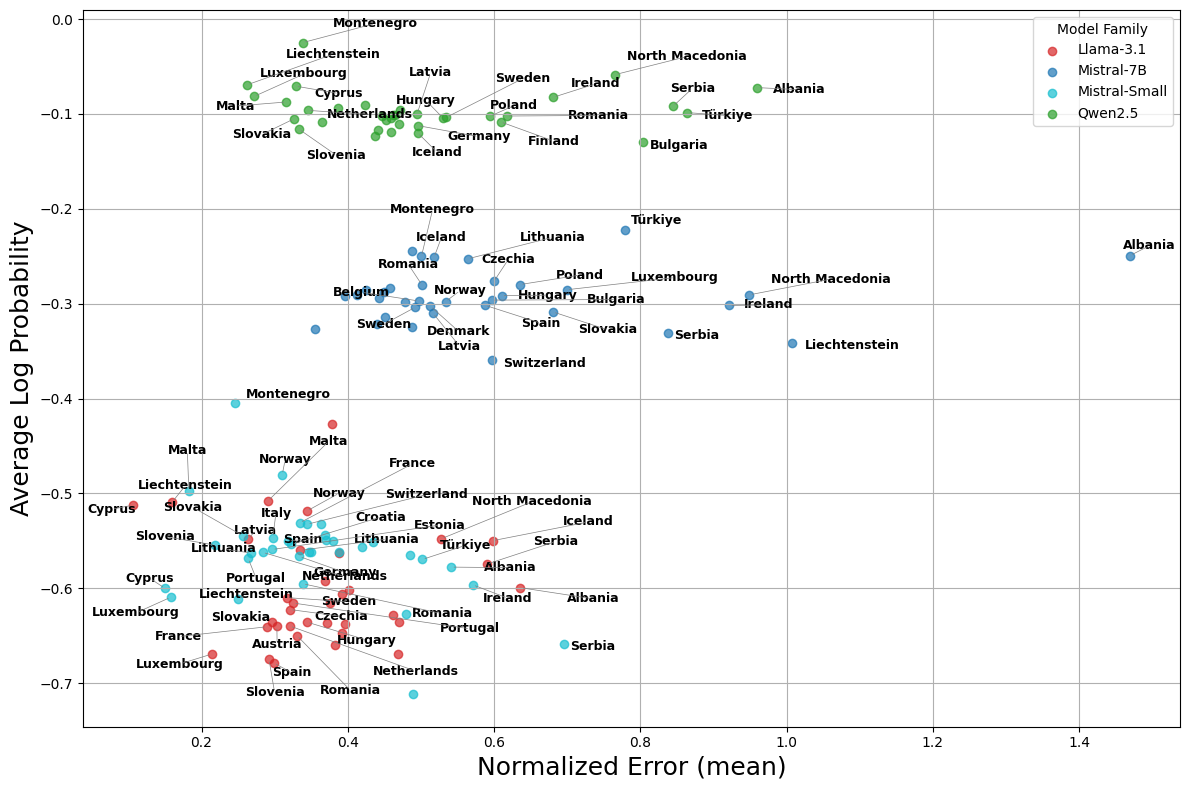

In [19]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Grouper par pays et modèle
grouped = df_filtered.groupby(["country", "model"])[["normalized_error", "logprobs"]].mean().reset_index()

# Familles de modèles et leurs couleurs
model_colors = {
    'Mistral-7B': 'tab:blue',
    'Mistral-Small': 'tab:cyan',
    'Qwen2.5': 'tab:green',
    'Llama-3.1': 'tab:red'
}

# Fonction pour déterminer la famille de modèle
def get_family(model_name):
    if "Mistral-7" in model_name:
        return "Mistral-7B"
    elif "Mistral-Small" in model_name:
        return "Mistral-Small"
    elif "Qwen2.5" in model_name:
        return "Qwen2.5"
    elif "Llama-3.1" in model_name:
        return "Llama-3.1"
    else:
        return "Other"

grouped["family"] = grouped["model"].apply(get_family)

grouped = grouped.groupby(["country", "family"])[["normalized_error", "logprobs"]].mean().reset_index()

# Plot
TOP_K = 45  # Change this number based on how many countries you want to annotate

# Get top and bottom k countries by normalized error (absolute value optional)
top_k_rows = grouped.nlargest(TOP_K, "normalized_error")
bottom_k_rows = grouped.nsmallest(TOP_K, "normalized_error")
label_rows = pd.concat([top_k_rows, bottom_k_rows])

# Plot base
plt.figure(figsize=(12, 8))
texts = []

# Scatter by model family
for family, data in grouped.groupby("family"):
    plt.scatter(data["normalized_error"], data["logprobs"],
                label=family, color=model_colors.get(family, 'gray'), alpha=0.7)

# Label only selected countries
for _, row in label_rows.iterrows():
    texts.append(
        plt.text(row["normalized_error"], row["logprobs"], row["country"],
                 fontsize=9, weight='bold')
    )

# Adjust label positions
adjust_text(
    texts,
    arrowprops=dict(arrowstyle="-", color='gray', lw=0.5),
    force_points=0.3,
    force_text=0.5,
    expand_points=(1.2, 1.4),
    expand_text=(1.2, 1.4),
    only_move={'points': 'y', 'text': 'xy'},
    lim=200
)

#plt.title("LLM Confidence vs. Normalized Error per Country", fontsize=16)
plt.xlabel("Normalized Error (mean)", fontsize=18)
plt.ylabel("Average Log Probability", fontsize=18)
plt.grid(True)
plt.legend(title="Model Family")
plt.tight_layout()
plt.show()

## Focus on particular model

In [22]:
# Datafiles

# MODEL = "Qwen/Qwen2.5-7B-Instruct"  
# model_short_name = "Qwen2.5-7B-Instruct"

# Llama-3.1-70B-Instruct
MODEL = "meta-llama/Llama-3.1-70B-Instruct"  
model_short_name = "Llama-3.1-70B-Instruct"

# Mistral-Small-24B-Instruct-2501
MODEL = "mistralai/Mistral-Small-24B-Instruct-2501"  
model_short_name = "Mistral-Small-24B-Instruct-2501"

data_dir = "output/bash"
eurostat_data_files = [
    {
        "indicator": "income",
        "path_absolute": f"{data_dir}/income_2017_nuts_llm_{model_short_name}_absolute.csv",
        "path_relative": f"{data_dir}/income_2017_nuts_llm_{model_short_name}_relative.csv",
        "complete_year": "2017",
        "unit": "EUR_HAB"
    },
    {
        "indicator": "pop_density",
        "path_absolute": f"{data_dir}/pop_density_2018_nuts_llm_{model_short_name}_absolute.csv",
        "path_relative": f"{data_dir}/pop_density_2018_nuts_llm_{model_short_name}_relative.csv",
        "complete_year": "2018",
        "unit": "PER_KM2",
        "nan": ":", # null value are ":" and not empty cell
    },
    {
        "indicator": "poverty",
        "path_absolute": f"{data_dir}/poverty_2022_nuts_llm_{model_short_name}_absolute.csv",
        "path_relative": f"{data_dir}/poverty_2022_nuts_llm_{model_short_name}_relative.csv",
        "complete_year": "2022",
        "unit": "PC",
        "nan": ":"
    },
    {
        "indicator": "age_index",
        "path_absolute": f"{data_dir}/age_index_2021_nuts_llm_{model_short_name}_absolute.csv",
        "path_relative": f"{data_dir}/age_index_2021_nuts_llm_{model_short_name}_relative.csv",
        "complete_year": "2021",
        "unit": "NR"
    }
]


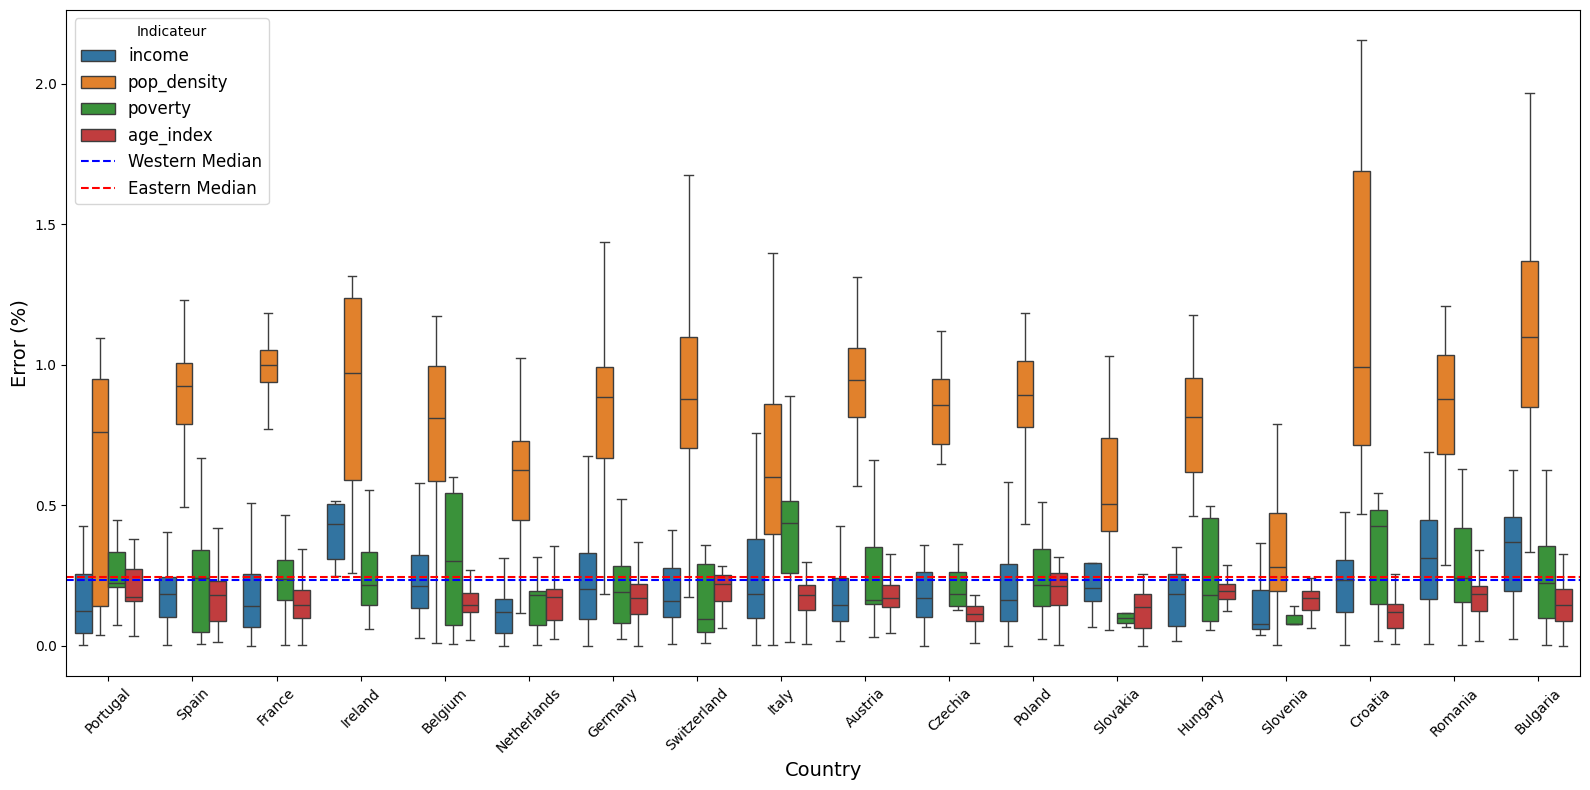

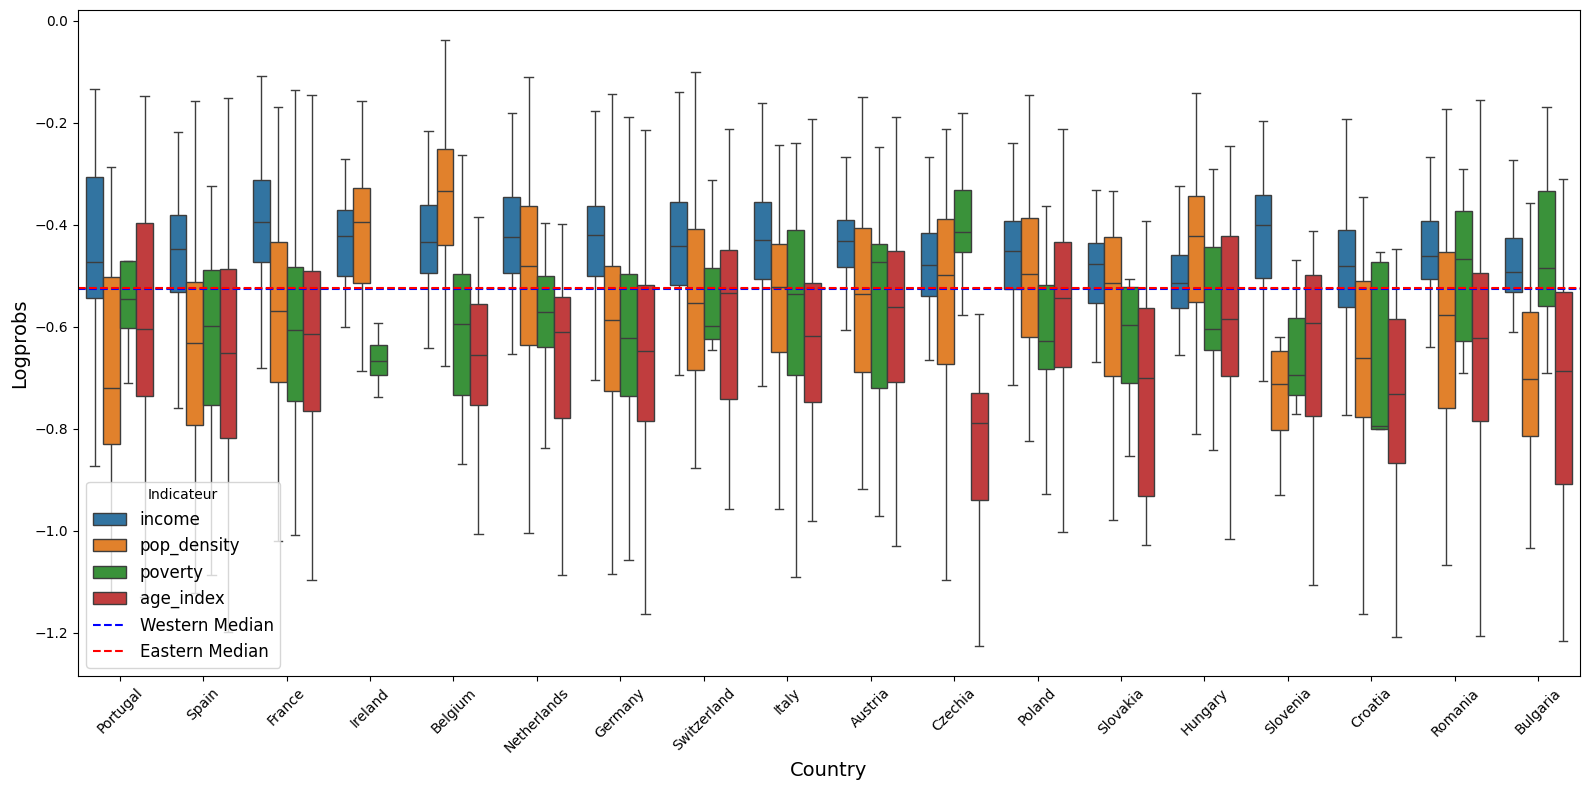

In [23]:
all_errors = []

for file_info in eurostat_data_files:
    indicator = file_info["indicator"]
    data = pd.read_csv(file_info["path_relative"])
    data[f"error"] = abs(data[f"{indicator}_relative_predicted"] - data[f"relative_{indicator}"]) / data[f"average_country_indicator"]
    data["logprobs"] = data[f'{indicator}_relative_logprobs']
    data["indicator"] = indicator
    
    # Append to the list
    all_errors.append(data[["country", f"error", 'logprobs', "indicator"]])

# Combine all data into a single DataFrame
combined_data = pd.concat(all_errors)
combined_data = combined_data.dropna(subset=["error"])
combined_data = combined_data.reset_index()

# Define geographic order of countries
geographic_order = [
    "Portugal", "Spain", "France", "Ireland", "United Kingdom", "Belgium", "Netherlands",
    "Germany", "Switzerland", "Italy", "Austria", "Czechia", "Poland",
    "Slovakia", "Hungary", "Slovenia", "Croatia", "Romania", "Bulgaria", "Greece"
]
western_countries = [
    "Portugal", "Spain", "France", "Ireland", "United Kingdom", "Belgium", 
    "Netherlands", "Germany", "Switzerland", "Italy", "Austria"
]
eastern_countries = [
    "Czechia", "Poland", "Slovakia", "Hungary", "Slovenia", 
    "Croatia", "Romania", "Bulgaria", "Greece"
]

countries_in_data = combined_data["country"].unique()
geographic_order_filtered = [country for country in geographic_order if country in countries_in_data]
western_median = combined_data[combined_data["country"].isin(western_countries)]["error"].median()
eastern_median = combined_data[combined_data["country"].isin(eastern_countries)]["error"].median()

# Create the boxplot
plt.figure(figsize=(16, 8))
sns.boxplot(
    x="country", y="error", hue="indicator", data=combined_data,
    order=geographic_order_filtered,
    showfliers=False
)
plt.axhline(y=western_median, color="blue", linestyle="--", label="Western Median")
plt.axhline(y=eastern_median, color="red", linestyle="--", label="Eastern Median")
# Customize the plot
# plt.title(f"Boxplot of error during relative prediction of 4 indicators with {model_short_name}", fontsize=16)
plt.xlabel("Country", fontsize=14)
plt.ylabel("Error (%)", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Indicateur", fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()


western_median = combined_data[combined_data["country"].isin(western_countries)]["logprobs"].median()
eastern_median = combined_data[combined_data["country"].isin(eastern_countries)]["logprobs"].median()
plt.figure(figsize=(16, 8))
sns.boxplot(
    x="country", y="logprobs", hue="indicator", data=combined_data,
    order=geographic_order_filtered, 
    showfliers=False
)

plt.axhline(y=western_median, color="blue", linestyle="--", label="Western Median")
plt.axhline(y=eastern_median, color="red", linestyle="--", label="Eastern Median")
# Customize the plot
# plt.title(f"Boxplot of logprobs during relative prediction of 4 indicators with {model_short_name}", fontsize=16)
plt.xlabel("Country", fontsize=14)
plt.ylabel("Logprobs", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Indicateur", fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()

## Degree of deviation

In [24]:
df_filtered

,NUTS_NAME,LEVL_CODE,country,predicted,error_deviation,normalized_error_deviation,logprobs,logprobs_deviation,error,normalized_error,indicator,expe,model
0,Nordburgenland,3,Austria,6.0,6.0,0.171429,-0.590775,0.507814,5.0,0.142857,age_index,relative,Mistral-Small-24B-Instruct-2501
1,Südburgenland,3,Austria,5.0,8.0,0.228571,-0.615942,0.720973,3.0,0.085714,age_index,relative,Mistral-Small-24B-Instruct-2501
2,Mittelburgenland,3,Austria,7.0,8.0,0.228571,-0.445966,0.632117,5.0,0.142857,age_index,relative,Mistral-Small-24B-Instruct-2501
3,Weinviertel,3,Austria,9.0,3.0,0.085714,-0.347870,0.407123,8.0,0.228571,age_index,relative,Mistral-Small-24B-Instruct-2501
4,Liezen,3,Austria,9.0,4.0,0.114286,-0.501073,0.511359,7.0,0.200000,age_index,relative,Mistral-Small-24B-Instruct-2501
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80966,Ortadoğu Anadolu,1,Türkiye,10625.0,744.0,0.100270,-0.185244,0.074380,5925.0,1.260638,income,absolute,Mistral-7B-Instruct-v0.3
80968,Slovenija,1,Slovenia,23810.0,672.0,0.035533,-0.292342,0.113341,3010.0,0.144712,income,absolute,Mistral-7B-Instruct-v0.3
80969,Slovensko,1,Slovakia,20420.0,312.0,0.018706,-0.267152,0.091524,4820.0,0.308974,income,absolute,Mistral-7B-Instruct-v0.3
80972,Batı Marmara,1,Türkiye,12200.0,1135.0,0.152965,-0.264254,0.128684,2500.0,0.257732,income,absolute,Mistral-7B-Instruct-v0.3


In [25]:
df_std = df_filtered.groupby("country")[["normalized_error", "normalized_error_deviation", "logprobs", "logprobs_deviation"]].mean()
df_std

,normalized_error,normalized_error_deviation,logprobs,logprobs_deviation
country,,,,
Albania,0.883004,0.351554,-0.288580,0.169994
Austria,0.409617,0.082225,-0.322453,0.162759
Belgium,0.432875,0.064094,-0.316057,0.162605
Bulgaria,0.632912,0.175146,-0.321727,0.155916
Croatia,0.425894,0.099112,-0.304382,0.159177
Cyprus,0.262609,0.062821,-0.274103,0.153716
Czechia,0.438310,0.094432,-0.306362,0.163536
Denmark,0.445263,0.078579,-0.307311,0.168892
Estonia,0.414557,0.132266,-0.319088,0.154104


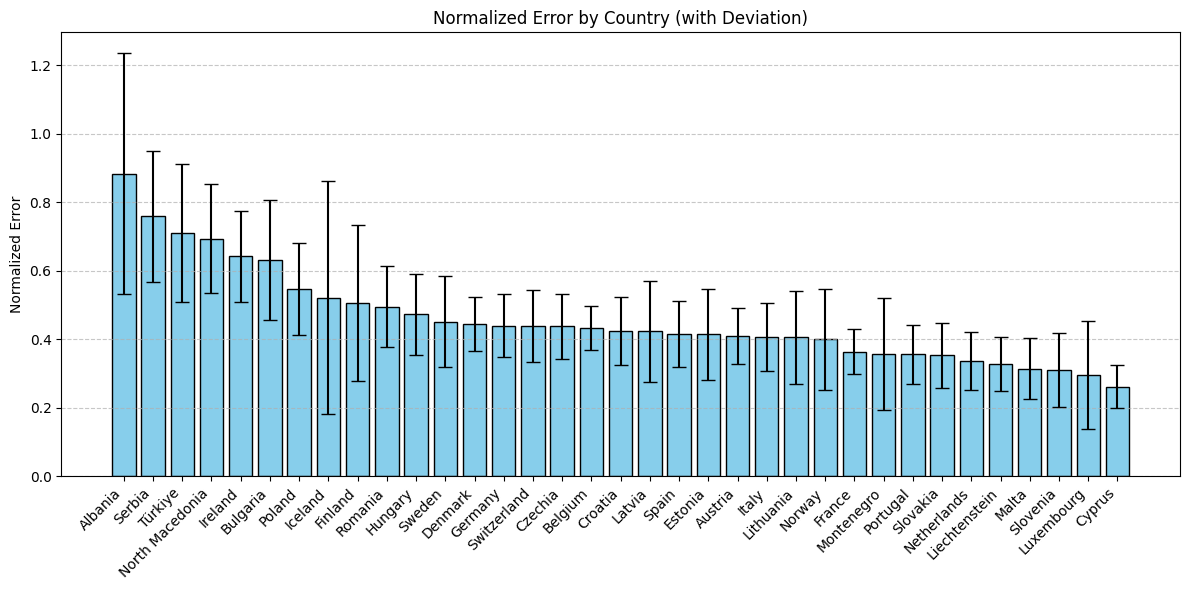

In [26]:
df_sorted = df_std.sort_values('normalized_error', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(df_sorted.index, df_sorted['normalized_error'], yerr=df_sorted['normalized_error_deviation'], capsize=5, color='skyblue', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Normalized Error')
plt.title('Normalized Error by Country (with Deviation)')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### with color corresponding to income revenue

In [28]:
df_income = pd.read_csv("output/eurostat_income_2017.csv")
df_income

,Unnamed: 0,CNTR_CODE,NUTS_NAME,NUTS_ID,LEVL_CODE,unit,data,2017,average_country_indicator,relative_income,geometry
0,0,AT,Nordburgenland,AT112,3,EUR_HAB,32400.0,32400.0,38958,-6558.0,"POLYGON ((4847876.7194 2800183.532299999, 4847..."
1,1,AT,Südburgenland,AT113,3,EUR_HAB,27000.0,27000.0,38958,-11958.0,POLYGON ((4796225.9728999995 2720427.994200000...
2,2,AL,Dibër,AL011,3,EUR_HAB,3000.0,3000.0,3618,-618.0,"POLYGON ((5179983.544 2144882.9366999995, 5179..."
3,3,AL,Durrës,AL012,3,EUR_HAB,4100.0,4100.0,3618,482.0,POLYGON ((5139659.721899999 2104822.9527000003...
4,4,AL,Kukës,AL013,3,EUR_HAB,2500.0,2500.0,3618,-1118.0,"POLYGON ((5152332.1678 2213667.282299999, 5156..."
...,...,...,...,...,...,...,...,...,...,...,...
1695,1695,SE,Sverige,SE,0,EUR_HAB,47700.0,47700.0,43170,4530.0,MULTIPOLYGON (((4972068.9427000005 4790066.824...
1696,1696,SI,Slovenija,SI,0,EUR_HAB,20800.0,20800.0,18912,1888.0,"POLYGON ((4796604.926899999 2660336.457800001,..."
1697,1697,PT,Portugal,PT,0,EUR_HAB,19000.0,19000.0,16726,2274.0,MULTIPOLYGON (((2828494.6108 2296190.204199999...
1698,1698,SK,Slovensko,SK,0,EUR_HAB,15600.0,15600.0,16679,-1079.0,"MULTIPOLYGON (((5003133.9245 2988592.0383, 500..."


In [29]:
import pycountry
df_income["country"] = df_income["CNTR_CODE"].apply(lambda code: pycountry.countries.get(alpha_2=code).name if pycountry.countries.get(alpha_2=code) else "Unknown")

df_income = df_income[["country", "average_country_indicator"]]

df_income = df_income.drop_duplicates(subset=["country"])
df_income

,country,average_country_indicator
0,Austria,38958
2,Albania,3618
35,Belgium,33414
84,Bulgaria,5797
113,Switzerland,71369
140,Czechia,17433
147,Cyprus,23600
158,Germany,37142
308,Denmark,48106
340,Unknown,14290


In [30]:
df_merged = df_std.merge(df_income, on='country', how='left')

In [31]:

high_threshold = df_merged['average_country_indicator'].quantile(0.66)
low_threshold = df_merged['average_country_indicator'].quantile(0.33)

def categorize_income(val):
    if val >= high_threshold:
        return 'high'
    elif val <= low_threshold:
        return 'low'
    else:
        return 'medium'

df_merged['income_group'] = df_merged['average_country_indicator'].apply(categorize_income)

color_map = {
    'high': '#A8E6CF',    # pastel green
    'medium': '#FFD3B6',  # pastel orange
    'low': '#FF8B94'      # pastel red/pink
}
df_merged['bar_color'] = df_merged['income_group'].map(color_map)


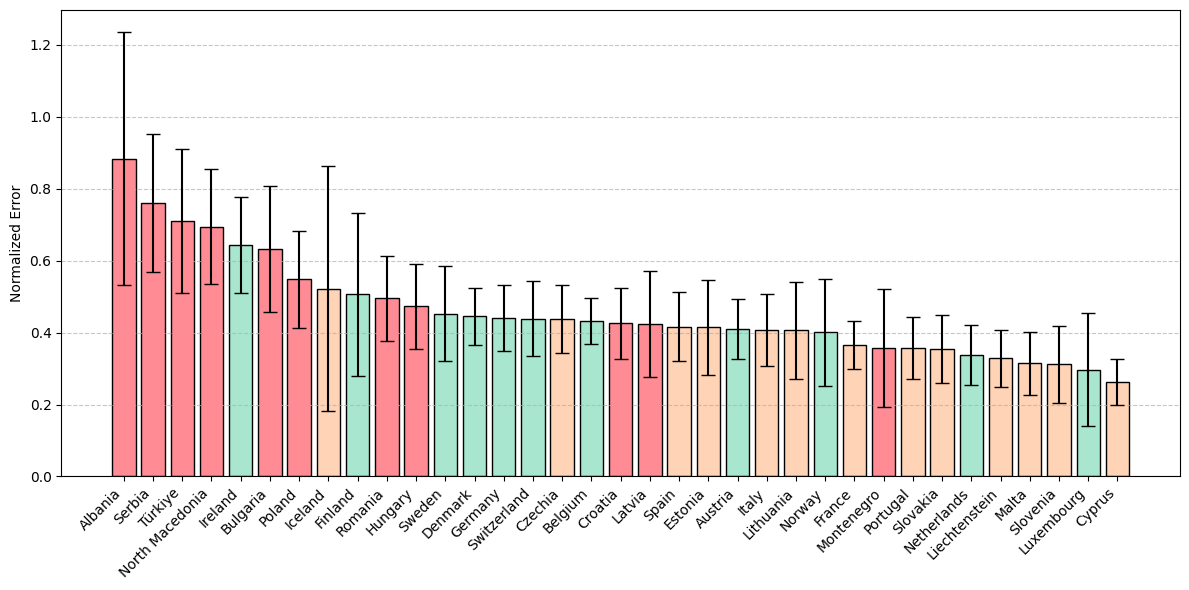

In [32]:
import matplotlib.pyplot as plt

df_sorted = df_merged.sort_values('normalized_error', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(
    df_sorted['country'],
    df_sorted['normalized_error'],
    yerr=df_sorted['normalized_error_deviation'],
    color=df_sorted['bar_color'],
    capsize=5,
    edgecolor='black'
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Normalized Error')
#plt.title('Normalized Error by Country Colored by Income Group')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

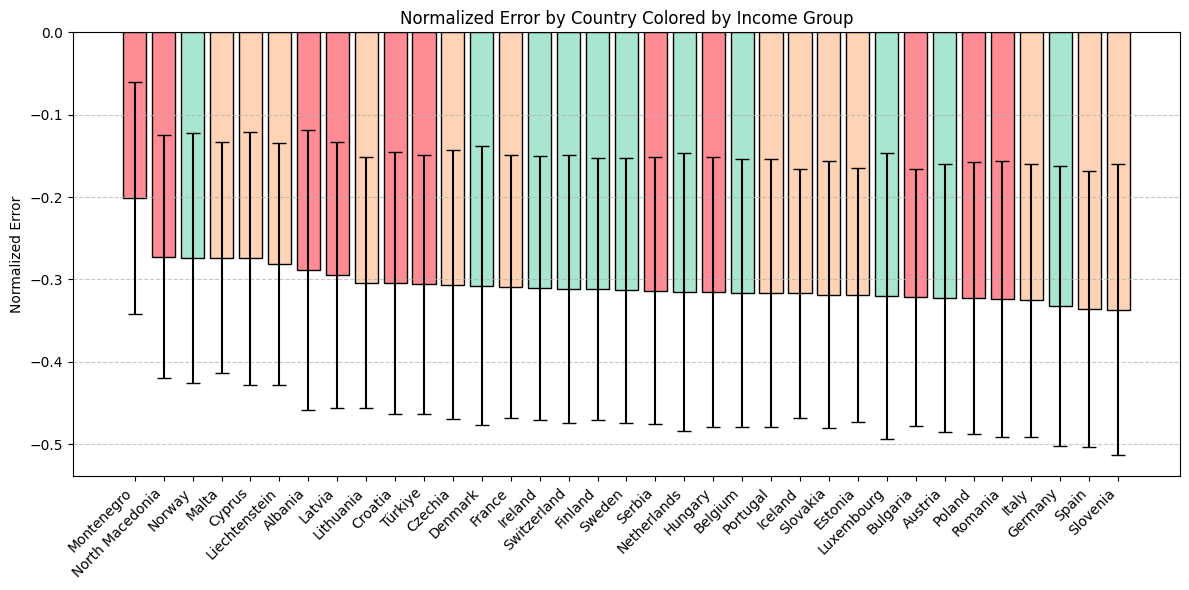

In [33]:
import matplotlib.pyplot as plt

df_sorted = df_merged.sort_values('logprobs', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(
    df_sorted['country'],
    df_sorted['logprobs'],
    yerr=df_sorted['logprobs_deviation'],
    color=df_sorted['bar_color'],
    capsize=5,
    edgecolor='black'
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Normalized Error')
plt.title('Normalized Error by Country Colored by Income Group')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [34]:
df_sorted

,country,normalized_error,normalized_error_deviation,logprobs,logprobs_deviation,average_country_indicator,income_group,bar_color
21,Montenegro,0.357086,0.163616,-0.200920,0.140369,6900.0,low,#FF8B94
23,North Macedonia,0.694362,0.160068,-0.272264,0.147835,5009.0,low,#FF8B94
24,Norway,0.400573,0.147872,-0.273450,0.151697,56412.0,high,#A8E6CF
20,Malta,0.314523,0.088383,-0.273463,0.140111,23500.0,medium,#FFD3B6
5,Cyprus,0.262609,0.062821,-0.274103,0.153716,23600.0,medium,#FFD3B6
17,Liechtenstein,0.328400,0.079775,-0.281006,0.146505,NaN,medium,#FFD3B6
0,Albania,0.883004,0.351554,-0.288580,0.169994,3618.0,low,#FF8B94
16,Latvia,0.423634,0.146948,-0.294376,0.161600,11480.0,low,#FF8B94
18,Lithuania,0.405761,0.134643,-0.304011,0.152203,13200.0,medium,#FFD3B6
4,Croatia,0.425894,0.099112,-0.304382,0.159177,10585.0,low,#FF8B94


In [35]:
summary = df_sorted.groupby("income_group").agg({
    "normalized_error": "mean",
    "normalized_error_deviation": "mean",
    "logprobs": "mean",
    "logprobs_deviation": "mean"
}).reset_index()

# Convert values into interpretable percentages where needed
summary["error_%"] = summary["normalized_error"] * 100
summary["error_range_%"] = summary["normalized_error_deviation"] * 100
summary["logprobs_mean"] = summary["logprobs"]  # Already interpretable (log scale)
summary["logprobs_range"] = summary["logprobs_deviation"]  # Standard deviation in log space

# Display
print(summary[["income_group", "error_%", "error_range_%", "logprobs_mean", "logprobs_range"]])

  income_group    error_%  error_range_%  logprobs_mean  logprobs_range
0         high  43.654813      11.837985      -0.312078        0.163822
1          low  58.209339      16.888932      -0.296639        0.159182
2       medium  37.659156      11.416767      -0.308922        0.158090


In [36]:
from scipy.stats import f_oneway

f_error, p_error = f_oneway(
    df_sorted[df_sorted["income_group"] == "low"]["normalized_error"],
    df_sorted[df_sorted["income_group"] == "medium"]["normalized_error"],
    df_sorted[df_sorted["income_group"] == "high"]["normalized_error"]
)
print(f"ANOVA (error rate): F = {f_error:.3f}, p = {p_error:.4f}")

ANOVA (error rate): F = 10.219, p = 0.0004
